# EOF Analysis of NEMO surface tracers

***

In [1]:
import numpy as np
import xarray as xr
import roman
from scipy import signal, fft
from matplotlib import pyplot as plt, colors, dates
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

## Load data

Parameters

In [211]:
# Subdomain
subdomain = [115, 360, 310, 788]

# Results path
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben-hg/data'

# Load NEMO netCDF files (concatentated using NCO)
mask_NEMO = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

# Slicing and indexing
skip = 5
loc = (0, 0, slice(*subdomain[2:], skip), slice(*subdomain[:2], skip))
tmask = mask_NEMO.tmask[loc].values.reshape(-1).astype(bool)
gridx, gridy = [var.reshape(-1)[tmask] for var in np.meshgrid(mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]])]

# Nitrate cutoff threshold
threshold, lag = 2, 5

Load, reshape and concatenate results

In [10]:
# Load results
data = {}
for key in ['raw', 'filtered']:
    data[key] = {'HRDPS': [], 'tau': [], 'votemper': [], 'nitrate': []}
for year in tqdm(range(2015, 2020)):

    # Load HRDPS
    fn = f'{path}/GEM25/HRDPS_ops_{year}0101_{year}1231.nc'
    with xr.open_dataset(fn) as ds:

        # Meshmask cut off inlets and JdF
        mask = ds.meshmask.values
        mask[:20, :20] = 0
        for lim in [(38, 48), (57, 30)]:
            mask[lim[0]:, lim[1]:] = 0
        mask = mask.reshape(-1).astype('bool')

        # Alongaxis wind
        u, v = [ds[var].values.reshape(-1, len(mask))[:, mask] for var in ['u_wind', 'v_wind']]
        jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180))

        # Process and concatenate
        data['raw']['HRDPS'].append((jtau * np.sqrt(u**2 + v**2)).mean(axis=1))
        data['raw']['tau'].append((jtau * 1.22e-3 * (u**2 + v**2)).mean(axis=1))

    # Load SalishSeaCast
    fn = f'{path}/SalishSeaCast/SalishSea_1h_{year}0101_{year}1231_grid_T.nc'
    with xr.open_dataset(fn) as ds:
        for var in ['votemper', 'nitrate']:
            data['raw'][var].append(ds[var].values[:, ::skip, ::skip].reshape(-1, len(tmask))[:, tmask])

# Concatenate and filter
for key in data['raw']:
    if key in ['HRDPS', 'tau']:
        data['raw'][key] = np.hstack(data['raw'][key])
        window = signal.get_window('blackman', 25)
        data['filtered'][key] = signal.convolve(data['raw'][key], window / sum(window), mode='same')
    else:
        data['raw'][key] = np.vstack(data['raw'][key])
        m, n = data['raw'][key].shape
        window = signal.get_window('blackman', 1235)
        data['filtered'][key] = np.empty((m, n))
        for i, col in zip(range(n), data['raw'][key].T):
            data['filtered'][key][:, i] = col - signal.convolve(col, window / sum(window), mode='same')

# Time array
data['time'] = np.array([datetime(2015, 1, 1) + timedelta(hours=h) for h in range(24*(365*5+1))])

# Seasonal indexing
nitrate_median = np.median(data['raw']['nitrate'], axis=1)
isegments, iseason = [], []
for year in range(2015, 2020):
    mask = (data['time'] < datetime(year, 1, 1)) | (data['time'] > datetime(year+1, 1, 1))
    bounds = np.ma.where(np.ma.masked_where(mask, nitrate_median) < threshold)[0][[0, -1]]
    bounds = [bound + lag * hour for bound, hour in zip(bounds, [24, -24])]
    isegments.append(bounds)
    iseason.append(np.arange(*bounds))
iseason = np.hstack(iseason)

In [212]:
# Seasonal indexing
nitrate_median = np.median(data['raw']['nitrate'], axis=1)
isegments, iseason = [], []
for year in range(2015, 2020):
    mask = (data['time'] < datetime(year, 1, 1)) | (data['time'] > datetime(year+1, 1, 1))
    bounds = np.ma.where(np.ma.masked_where(mask, nitrate_median) < threshold)[0][[0, -1]]
    bounds = [bound + lag * hour for bound, hour in zip(bounds, [24, -24])]
    isegments.append(bounds)
    iseason.append(np.arange(*bounds))
iseason = np.hstack(iseason)

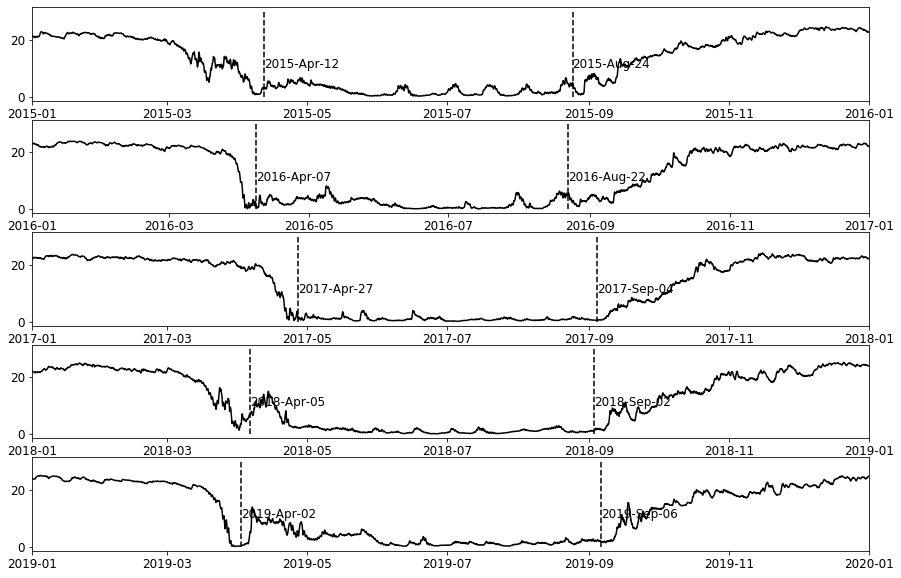

In [214]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))
for ax, year, isegment in zip(axs, range(2015, 2020), isegments):
    ax.plot(data['time'], nitrate_median, 'k-')
    for i in isegment:
        ax.plot(np.repeat(data['time'][i], 2), [0, 30], 'k--')
        ax.text(data['time'][i], 10, data['time'][i].strftime('%Y-%b-%d'))
    ax.set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])

***

## Calculate EOFs

Functions

In [72]:
def varimax(A, maxiter=30, tol=1e-5):
    """Calculate the varimax rotation matrix H from the n x p PC loadings matrix A. H is determined
    iteratively from the Lagrange multiplier optimization of the varimax criterion.
    
    Adapted from:
    
    Horst, P. (1965) Factor Analysis of Data Matrices. Holt, Rinehart and Winston. New York, USA.
    Chapter 18: Analytical Rotations
        - Section 18.4: Simultaneous Factor Varimax Solution, Equations 18.4.1-10, pp. 428-429
        - Section 18.7: Mathematical Proofs, Equations 18.7.32-54, pp. 437-438
    
    The algorithm described in Section 18.4 has been reformulated to use SVD based on equivalent
    definitions for the rotation matrix described in Section 18.7. The eigenvalue matrix is used
    to evaluate convergence.
    
    This version of the varimax algorithm is functionally identical to those found in Sci-kit learn,
    Matlab, R, and presumably others.
    """
    
    # Initialization
    n, p = A.shape
    H = np.eye(p)
    d = 0
    
    # Iteration
    for i in tqdm(range(maxiter)):
        d_old = d
        B = A.dot(H)  # -------------------------------------------------------- 18.4.5
        beta = B * B * B - B.dot(np.diag(np.diag(B.T.dot(B)))) / n  # ---------- 18.4.6
        P, Delta, Q_T = np.linalg.svd(A.T.dot(beta))  # ------------------------ 18.7.42
        H = P.dot(Q_T)  # ------------------------------------------------------ 18.7.45
        d = sum(Delta)
        
        # Convergence
        if d_old != 0 and d/d_old < 1 + tol: break

    return H

In [110]:
def calc_EOF(z, rotate=True):
    """Calculate EOF matrices of n x p data matrix z using SVD
    and optional varimax rotation
    """
    
    # EOF dict
    EOF = {}
    
    # Calculate orthogonal EOF matrices
    A_prime, sqrtL, E_T = np.linalg.svd(z, full_matrices=False)
    EOF['A'] = A_prime.dot(np.diag(sqrtL))
    A2 = EOF['A'] * EOF['A']
    EOF['var'] = A2.sum(axis=0) / A2.sum()
    EOF['E'] = E_T.T
    
    # Calculate rotated matrices
    if rotate:

        # Get varimax rotation matrix
        R, convergence = varimax(EOF['A'])

        # Rotate matrices
        EOF['B'] = EOF['A'].dot(R)
        B2 = EOF['B'] * EOF['B']
        EOF['var_rot'] = B2.sum(axis=0) / B2.sum()
        EOF['U'] = EOF['E'].dot(R)
        
        # Sort rotated matrices
        isort = EOF['var_rot'].argsort()[::-1]
        EOF['var_rot'] = EOF['var_rot'][isort]
        EOF['B'] = EOF['B'][:, isort]
        EOF['U'] = EOF['U'][:, isort]
    
    return EOF

Calculate EOFs

In [120]:
# Calculate EOFs
EOF = {}
for key in ['votemper', 'nitrate']:
    EOF[key] = calc_EOF(data['filtered'][key][iseason, :])

***

## Figures

### EOF spatial patterns

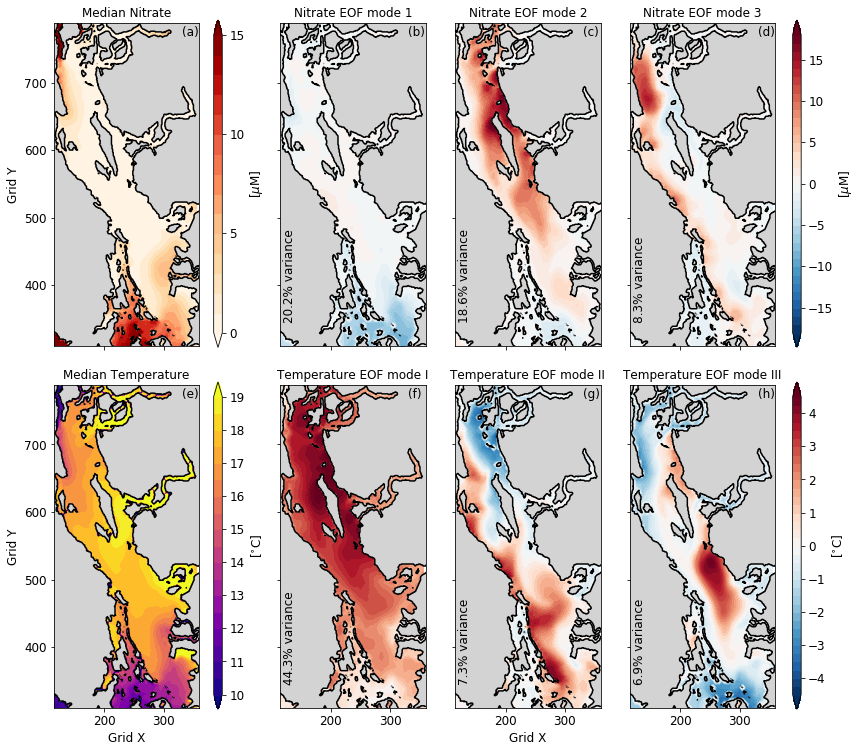

In [121]:
# Make figure and plotting params
fig, axs = plt.subplots(2, 4, figsize=(12, 13), gridspec_kw={'hspace': 0.05})

# Loop through variables
k = 0
levels1 = [(0, 15.1, 1, 0, 15.1, 5), (10, 19.1, 0.5, 10, 19.1, 1)]
levels2 = [(-18, 18.1, 1, -15, 15.1, 5), (-4.5, 4.6, 0.25, -4, 4.1, 1)]
units = ['[$\mu$M]', '[$^{\circ}$C]']
for row, key, label, level1, level2, unit, cmap in zip(
    axs, ['nitrate', 'votemper'], ['Nitrate', 'Temperature'], levels1, levels2, units, ['OrRd', 'plasma']
):
    
    # Plot mean field
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.06, pos.y0, pos.width, pos.height])
    gridded = np.zeros(mask_NEMO.nav_lon.shape)
    for y, x, val in zip(gridy, gridx, np.median(data['raw'][key][iseason, :], axis=0)): gridded[y, x] = val
    gridded = gridded[loc[2:]]
    c = row[0].contourf(
        mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]], gridded,
        levels=np.arange(*level1[:3]), cmap=cmap, extend='both',
    )
    for C in c.collections: C.set_edgecolor('face')
    row[0].set_ylabel('Grid Y')
    row[0].set_title(f'Median {label}', fontsize=12)
    if key == 'votemper':
        row[0].set_xlabel('Grid X')
        row[2].set_xlabel('Grid X')
    cax = fig.add_axes([0.25, pos.y0+0.01, 0.01, 0.35])
    cbar = fig.colorbar(c, cax=cax, ticks=np.arange(*level1[3:]), label=unit)
    cbar.solids.set_edgecolor('face')
    
    # Plot EOF modes
    for ax, mode in zip(row[1:], range(3)):
        norm = -np.percentile(abs(EOF[key]['B'][:, mode]), 99.7)
        #fac = -1 if (mode in [0, 3]) & (key == 'votemper') else 1
        gridded = np.zeros(mask_NEMO.nav_lon.shape)
        for y, x, val in zip(gridy, gridx, EOF[key]['U'][:, mode]): gridded[y, x] = val
        gridded = gridded[loc[2:]]
        c = ax.contourf(
            mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]], gridded*norm,
            levels=np.arange(*level2[:3]), cmap='RdBu_r', extend='both',
        )
        for C in c.collections: C.set_edgecolor('face')
        ax.text(0.02, 0.08, f"{EOF[key]['var_rot'][mode]*100:.01f}% variance", rotation=90, transform=ax.transAxes)
        ax.yaxis.set_ticklabels('')
        modelabel = roman.toRoman(mode+1) if key == 'votemper' else mode+1
        ax.set_title(f"{label} EOF mode {modelabel}", fontsize=12)

    # Formatting for all panels
    for ax in row:
        ax.contourf(mask_NEMO.x, mask_NEMO.y, mask_NEMO.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
        ax.contour(mask_NEMO.x, mask_NEMO.y, mask_NEMO.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        ax.set_xlim(subdomain[:2])
        ax.set_ylim(subdomain[2:])
        viz_tools.set_aspect(ax)
        ax.text(0.88, 0.96, f'({chr(97+k)})', transform=ax.transAxes)
        if key == 'nitrate': ax.xaxis.set_ticklabels('')
        k += 1

    # Add colorbar
    cax = fig.add_axes([0.92, pos.y0+0.01, 0.01, 0.35])
    cbar = fig.colorbar(c, cax=cax, ticks=np.arange(*level2[3:]), label=unit)
    cbar.solids.set_edgecolor('face')
    
#fig.savefig('/home/bmoorema/Desktop/EOF.pdf', bbox_inches='tight')

### Principle component time series

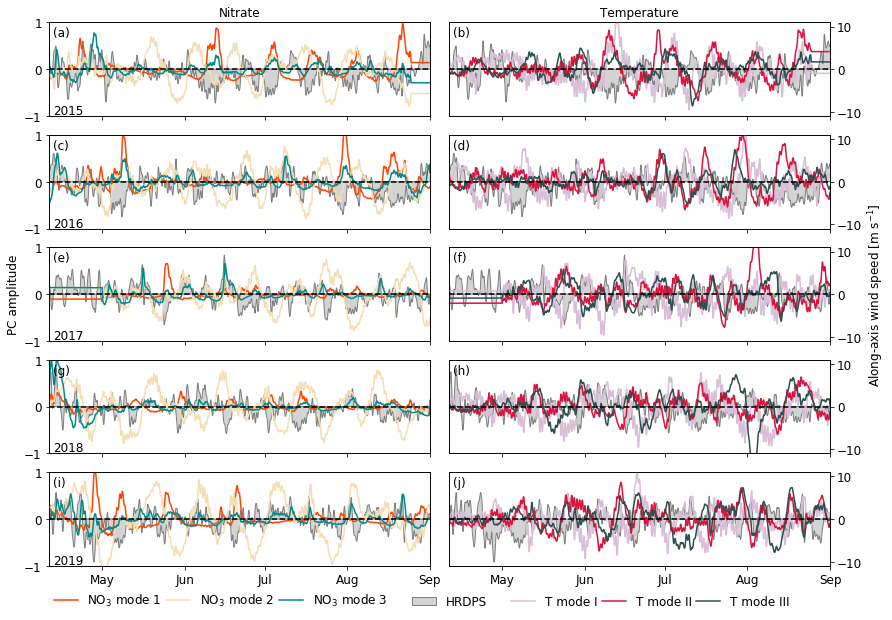

In [629]:
window = signal.get_window('blackman', 25)
modes = [(1, 2, 0), (0, 1, 3)]
palettes = [['orangered', 'wheat', 'darkcyan'], ['thistle', 'crimson', 'darkslategray']]
fig, axs = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw={'wspace': 0.05})
k = 0
l = []
for row, year in zip(axs, range(2015, 2020)):
    
    xlim = [datetime(year, *md) for md in [(4, 11), (9, 1)]]
    row[0].text(0.01, 0.02, year, transform=row[0].transAxes)
    
    # Loop through variables
    for ax, key, mode, label, label2, palette, xpos in zip(
        row, ['nitrate', 'votemper'], modes, ['Nitrate', 'Temperature'], ['NO$_3$', 'T'], palettes, [0, 0.15],
    ):
        
        # Set up axes
        ax.set_zorder(1)
        ax.patch.set_visible(False)
        ax2 = ax.twinx()
        ax2.set_ylim([-11, 11])
        ax.set_ylim([-1, 1])
        ax.set_xlim(xlim)
        if key == 'nitrate':
            ax2.yaxis.set_ticks([])
            if year == 2017: ax.set_ylabel('PC amplitude')
        else:
            ax.yaxis.set_ticks([])
            if year == 2017: ax2.set_ylabel('Along-axis wind speed [m s$^{-1}$]')
    
        # Plot wind and PCs
        ax2.fill_between(data['time'], data['filtered']['HRDPS'], facecolor='lightgray', edgecolor='gray', label='HRDPS')
        for n, m, color in zip(range(3), mode, palette):
            fac = -1 if (m in [0, 3]) & (key == 'votemper') else 1
            norm = -np.percentile(abs(EOF[key]['B'][:, m]), 99.7)
            PC = signal.convolve(fac*EOF[key]['B'][:, m]/norm, window / sum(window), mode='same')
            modelabel = roman.toRoman(n+1) if key == 'votemper' else n+1
            ax.plot(data['time'][iseason], PC, '-', color=color, label=f'{label2} mode {modelabel}')
        ax.xaxis.set_major_locator(getattr(dates, 'MonthLocator')())
        ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
        if year < 2019: ax.xaxis.set_ticklabels('')
        if year == 2015: ax.set_title(f'{label}', fontsize=12)
        ax.plot(xlim, [0, 0], 'k--')
        ax.text(0.01, 0.85, f'({chr(97+k)})', transform=ax.transAxes)
        k += 1

        if year == 2019: ax.legend(ncol=3, loc=(xpos, -0.5), frameon=False, columnspacing=0.4)
ax2.legend(loc=(-0.11, -0.5), frameon=False)
#fig.savefig('/home/bmoorema/Desktop/PC_timeseries.pdf', bbox_inches='tight')

### PC power spectra

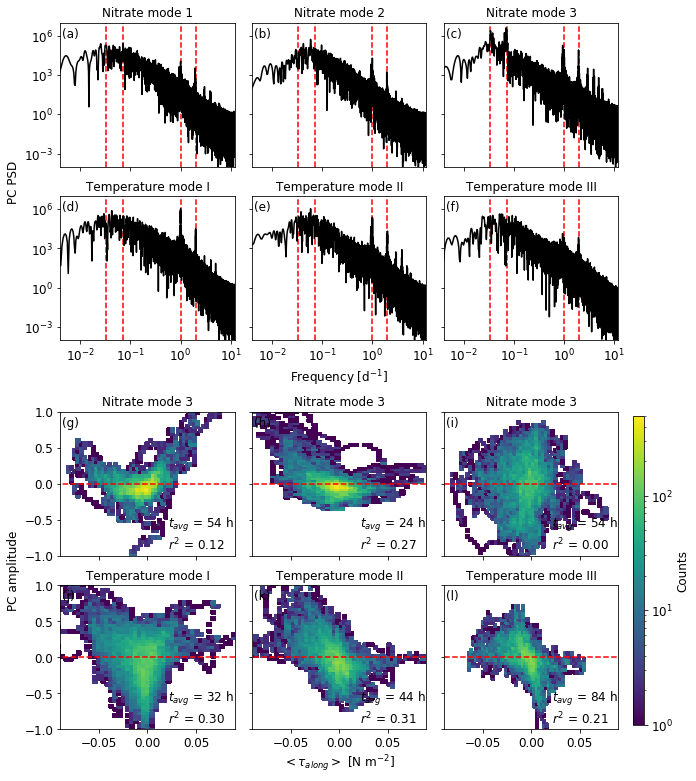

In [116]:
fig, axs = plt.subplots(4, 3, figsize=(10, 13), gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

freq = np.linspace(0, 12, 50001)
k=0
axs[1, 1].set_xlabel('Frequency [d$^{-1}$]')
axs[1, 0].set_ylabel('PC PSD', y=1.1)
for row, key, label in zip(axs[:2, :], ['nitrate', 'votemper'], ['Nitrate', 'Temperature']):

    for ax, mode in zip(row, range(3)):
        norm = -np.percentile(abs(EOF[key]['B'][:, mode]), 99.7)
        xlim, ylim = [4e-3, 12], [1e-4, 1e7]
        PSD = abs(fft.rfft(EOF[key]['B'][:, mode]/norm, n=100000))**2
        for peak, xpos in zip([0.5, 1, 14, 30], [0.75, 0.62, 0.33, 0.15]):
            ax.plot([1/peak, 1/peak], ylim, 'r--')
            #if (n == 1) and (key == 'votemper'): ax.text(xpos, 1.02, f'{peak} d', transform=ax.transAxes)
        ax.plot(freq, PSD, 'k-')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks([1e-2, 1e-1, 1e0, 1e1])
        ax.yaxis.set_ticks([1e-3, 1e0, 1e3, 1e6])
        ax.text(0.01, 0.9, f'({chr(97+k)})', transform=ax.transAxes)
        if mode > 0: ax.yaxis.set_ticklabels('')
        modelabel = roman.toRoman(mode+1) if key == 'votemper' else mode+1
        ax.set_title(f'{label} mode {modelabel}', fontsize=12)
        if key == 'nitrate':
            ax.xaxis.set_ticklabels('')
        else:
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0+0.015, pos.width, pos.height])
        k += 1

axs[3, 1].set_xlabel('$<\\tau_{along}>$ [N m$^{-2}$]')
axs[3, 0].set_ylabel('PC amplitude', y=1.1)
functions = [('less', None, 'greater'), ('less', None, None)]

for row, key, label, funcs in zip(axs[2:, :], ['nitrate', 'votemper'], ['Nitrate', 'Temperature'], functions):

    for ax, mode, func in zip(row, range(3), funcs):
        
        norm = -np.percentile(abs(EOF[key]['B'][:, mode]), 99.7)
        
        for w in range(70):
        tau_mean = []
        for segment in isegments:
            for i in range(*segment):
                tau_mean.append(data['raw']['tau'][i-min(i, w+1):i].mean())
        r2 = np.corrcoef(np.array(tau_mean), EOF[var]['B'][:, mode] / norm)[0, 1]**2
        
        
        ax.plot([-10, 10], [0, 0], 'r--')
        _, _, _, h = ax.hist2d(tau_mean, EOF[key]['B'][:, mode]/norm, bins=50, norm=colors.LogNorm(vmin=1, vmax=5e2))
        h.set_edgecolor('face')
        ax.set_xlim([-0.09, 0.09])
        ax.set_ylim([-1, 1])
        ax.text(0.01, 0.9, f'({chr(97+k)})', transform=ax.transAxes)
        ax.text(0.62, 0.04, f'$t_{{avg}}$ = {lag} h\n$r^2$ = {r2:0.2f}', transform=ax.transAxes)
        if mode > 0: ax.yaxis.set_ticklabels('')
        modelabel = roman.toRoman(mode+1) if key == 'votemper' else n+1
        ax.set_title(f'{label} mode {modelabel}', fontsize=12)
        if key == 'nitrate':
            ax.xaxis.set_ticklabels('')
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0-0.015, pos.width, pos.height])
        k += 1
        
cax = fig.add_axes([0.92, 0.13, 0.015, 0.33])
fig.colorbar(h, cax=cax, label='Counts')
#fig.savefig('/home/bmoorema/Desktop/PC_dependence.pdf', bbox_inches='tight')

In [ ]:
for w in range(70):
    tau_mean = []
    for segment in isegments:
        for i in range(*segment):
            tau_mean.append(data['raw']['tau'][i-min(i, w+1):i].mean())
    np.corrcoef(np.array(tau_mean), EOF[var]['B'][:, mode])[0, 1]**2

In [122]:
lags, windows = np.arange(6, 145, 6), np.arange(6, 97, 6)
r2 = np.empty((len(windows), len(lags)))
for col in tqdm(range(len(lags))):
    for row in range(len(windows)):
        tau_mean = []
        for segment in isegments:
            for i in range(*segment):
                tau_mean.append(np.nanmean(data['raw']['tau'][i-min(i, windows[row]+lags[col]):i-min(i, lags[col])]))
        tau_mean = np.array(tau_mean)
        r2[row, col] = np.corrcoef(tau_mean, EOF['votemper']['B'][:, 1])[0, 1]**2

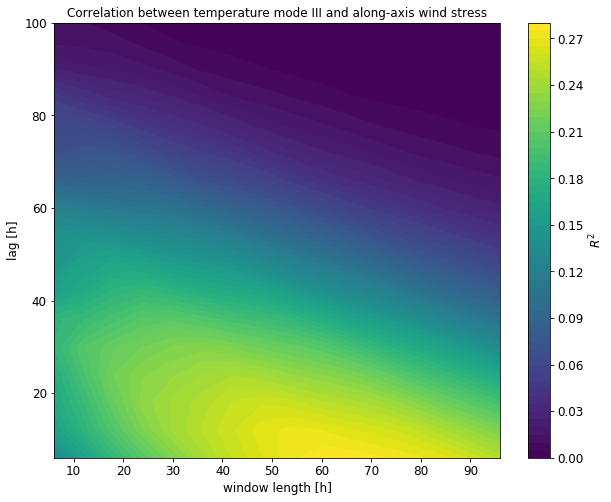

In [129]:
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.contourf(windows, lags, r2.T, levels=np.arange(0, 0.28, 0.005))
ax.set_xlabel('window length [h]')
ax.set_ylabel('lag [h]')
ax.set_title('Correlation between temperature mode III and along-axis wind stress', fontsize=12)
ax.set_ylim([6, 100])
fig.colorbar(c, label='$R^2$')
#fig.savefig('/home/bmoorema/Desktop/TmodeIIIlag.pdf')

In [201]:
rho_0 = 1e3
f = 1.11e-4
h = 10

tau = np.arange(0, 0.21, 0.01)

N = tau * 2 * np.sqrt(2) / (rho_0 * f * h**2)

$$N = \frac{2\sqrt{2}\tau}{\rho_0fh^2}$$

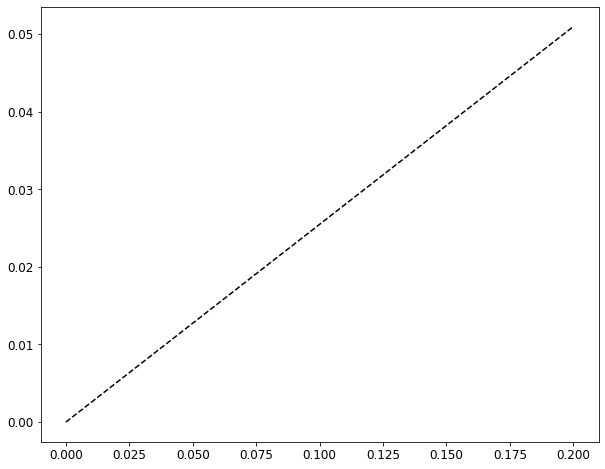

In [202]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tau, N, 'k--')